In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import calendar  
import re
import nltk
from nltk import download

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords  
from wordcloud import WordCloud


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import pickle



# Start of the EDA #

In [2]:
# I will start by loading and exploring the dataset and finding any issues within it
df = pd.read_csv('teste_indicium_precificacao.csv')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
df.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

In [4]:
df.describe()

df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [5]:
# dealing with the missing values

df.dropna(subset=['nome', 'host_name'], inplace=True)

# handling properly the nanß reviews (due to the lack of reviews)
df['ultima_review'] = df['ultima_review'].fillna('0001-01-01')
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)


# checking for remaining null values
df.describe()

df.isnull().sum()



id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [6]:
# I want to build the EDA in English, so for the sake of it I'm renaming the columns. 

# Dictionary for column renaming
column_mapping = {
    'id': 'listing_id',
    'nome': 'name',
    'host_id': 'host_id',
    'host_name': 'host_name',
    'bairro_group': 'neighborhood_group',
    'bairro': 'neighborhood',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'room_type': 'room_type',
    'price': 'price',
    'minimo_noites': 'minimum_nights',
    'numero_de_reviews': 'number_of_reviews',
    'ultima_review': 'last_review',
    'reviews_por_mes': 'reviews_per_month',
    'calculado_host_listings_count': 'calculated_host_listings_count',
    'disponibilidade_365': 'availability_365'
}

df.rename(columns=column_mapping, inplace=True)


In [7]:
before_stats = df.describe()
before_stats

,listing_id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.885700e+04,4.885700e+04,48857.000000,48857.00000,48857.000000,48857.000000,48857.000000,48857.000000,48857.000000,48857.000000
mean,1.902374e+07,6.763307e+07,40.728943,-73.95217,152.740385,7.012567,23.273390,1.091142,7.148392,112.796263
std,1.098267e+07,7.862410e+07,0.054527,0.04616,240.234843,20.019944,44.550307,1.597281,32.964937,131.607363
min,2.595000e+03,2.438000e+03,40.499790,-74.24442,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.476198e+06,7.821383e+06,40.690090,-73.98307,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.969118e+07,3.079133e+07,40.723070,-73.95568,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915779e+07,1.074344e+08,40.763110,-73.93628,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.71299,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [8]:
df['minimum_nights'].describe()
df.shape[0]

48857

In [9]:
df = df[df['minimum_nights'] <= 365]
df.shape[0]

48844

In [10]:
df.describe()

,listing_id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.884400e+04,4.884400e+04,48844.000000,48844.000000,48844.000000,48844.000000,48844.000000,48844.000000,48844.000000,48844.000000
mean,1.902508e+07,6.763965e+07,40.728942,-73.952168,152.749795,6.843215,23.278069,1.091389,7.149926,112.750287
std,1.098246e+07,7.862717e+07,0.054528,0.046164,240.264119,16.457372,44.555037,1.597413,32.969183,131.580057
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.476436e+06,7.822519e+06,40.690087,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.969192e+07,3.079915e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915804e+07,1.074344e+08,40.763110,-73.936270,175.000000,5.000000,24.000000,1.582500,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,365.000000,629.000000,58.500000,327.000000,365.000000


## Graph 1: scatter plot of price x number of reviews ##

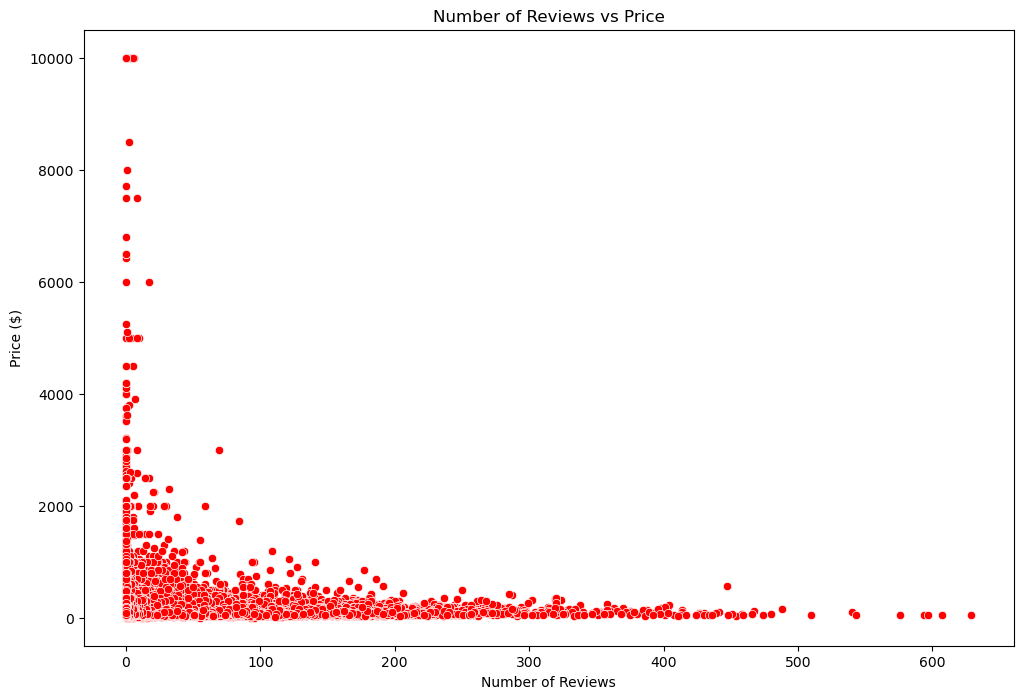

In [11]:

plt.figure(figsize=(12, 8))
sns.scatterplot(x='number_of_reviews', y='price', color ='red', data=df)
plt.title('Number of Reviews vs Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price ($)')
plt.show()


The graph shows a tendency: it is likely that the lower the price, the higher will be the odds of the customer leaving a review 

## Graph 2: scatter plot of Minimum Nights vs Number of Reviews ##

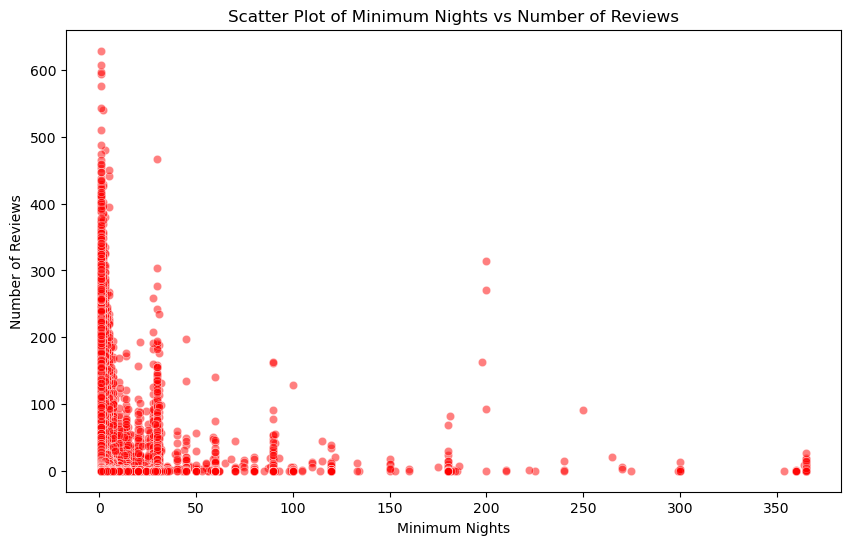

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minimum_nights', y='number_of_reviews', data=df,color ='red', alpha=0.5)
plt.title('Scatter Plot of Minimum Nights vs Number of Reviews')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Reviews')
plt.show()

## Graph 3: scatter plot of minimum nights vs price, with availability represented by color ##

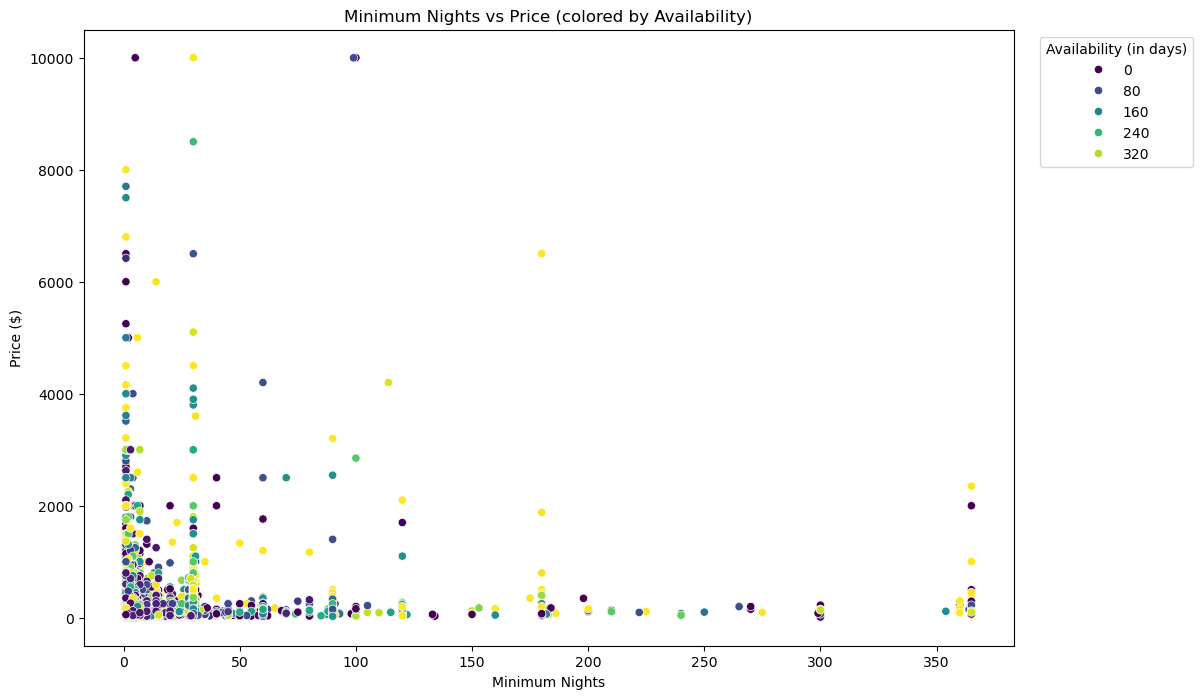

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='minimum_nights', y='price', hue='availability_365', palette='viridis', data=df)
plt.title('Minimum Nights vs Price (colored by Availability)')
plt.xlabel('Minimum Nights')
plt.ylabel('Price ($)')
plt.legend(title='Availability (in days)', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


1. As per the graph above, the minimum nights requirement seems to have a negative correlation to the price. Basically the higher the requirements for a min. night stay, the lower the price (NOT A cause-and-effect relationship!!!);
2. Alternatively, the availability seems to have a lessr correlation to price.

## Graph 4: bar plot of price x number of reviews ##

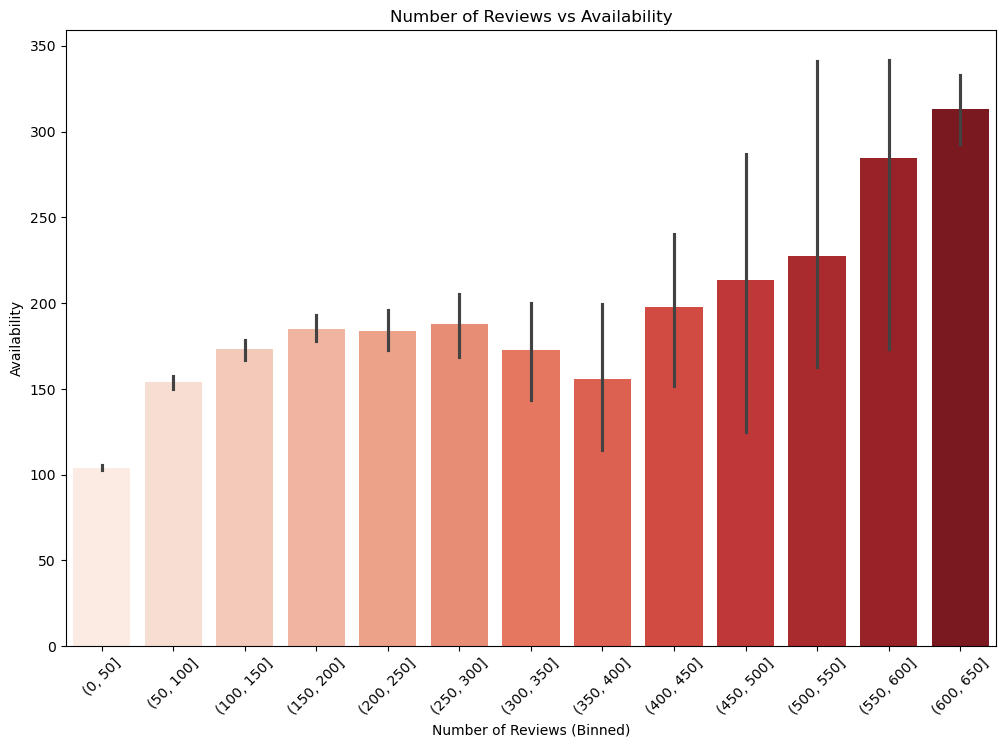

In [14]:
bin_edges = list(range(0, 651, 50))  

df['reviews_bins'] = pd.cut(df['number_of_reviews'], bins=bin_edges)
plt.figure(figsize=(12, 8))
sns.barplot(x='reviews_bins', y='availability_365', hue='reviews_bins', palette='Reds', data=df, legend=False)
plt.title('Number of Reviews vs Availability')
plt.xlabel('Number of Reviews (Binned)')
plt.ylabel('Availability')
plt.xticks(rotation=45)  
plt.show()

These graphs slightly show a positive correlation tendency with the number of reviews and the availability, even higher when looking at the negative corr. relating the number of reviews with minimum nights per stay, suggesting that properties with higher availability tend to receive more reviews and that the lower is the minimum required nights, the higher the customer is likely to leave a review. This could imply that properties with more open availability and less restrictive booking conditions attract more guests, leading to a higher likelihood of receiving reviews.

### Graph 5: rolling avg availability vs number of reviews (for the year2018) ###

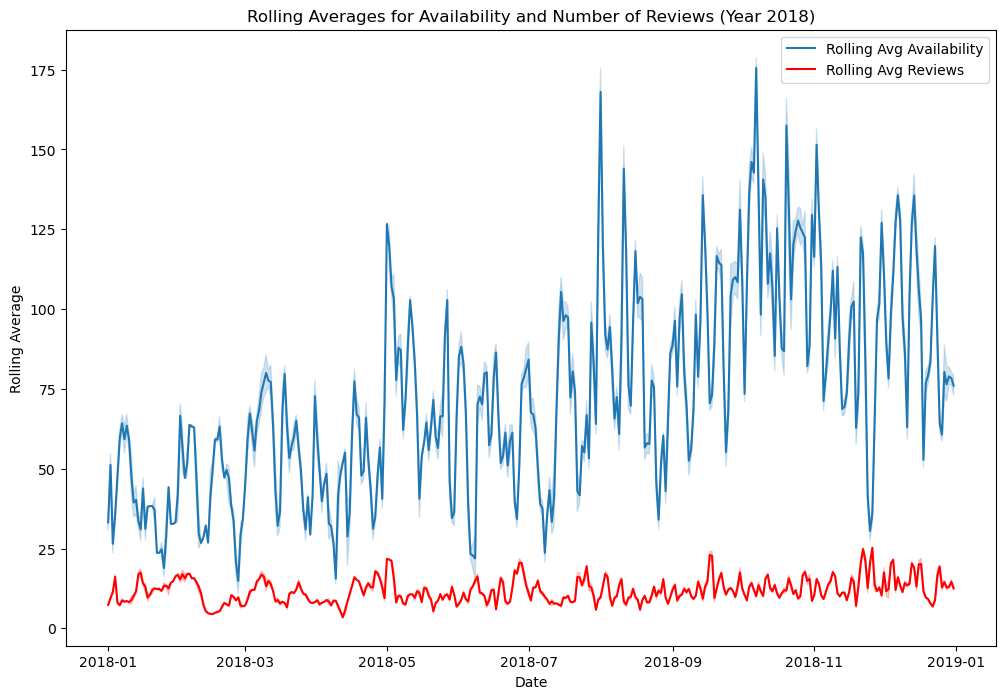

Correlation between rolling averages: 0.11262385430166541


In [15]:
df['last_review'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d', errors='coerce')

# having a lopk only at the data for the year 2018 (not picking 2019 because its incomplete)
df_2018 = df[df['last_review'].dt.year == 2018]
df_2018 = df_2018.sort_values(by='last_review')

# rolling averages for availability and n of revieww:
rolling_avg_availability = df_2018['availability_365'].rolling(window=30).mean()
rolling_avg_reviews = df_2018['number_of_reviews'].rolling(window=30).mean()

rolling_avg_df = pd.DataFrame({
    'last_review': df_2018['last_review'],
    'rolling_avg_availability': rolling_avg_availability,
    'rolling_avg_reviews': rolling_avg_reviews
})

plt.figure(figsize=(12, 8))
sns.lineplot(x='last_review', y='rolling_avg_availability', data=rolling_avg_df, label='Rolling Avg Availability')
sns.lineplot(x='last_review', y='rolling_avg_reviews', data=rolling_avg_df, label='Rolling Avg Reviews', color = 'red')
plt.title('Rolling Averages for Availability and Number of Reviews (Year 2018)')
plt.xlabel('Date')
plt.ylabel('Rolling Average')
plt.legend()
plt.show()

# caßßlculating the correlation between rolling averages
correlation = rolling_avg_df['rolling_avg_availability'].corr(rolling_avg_df['rolling_avg_reviews'])
print(f'Correlation between rolling averages: {correlation}')

### Graph 6: global avg prices per each month of the year ###

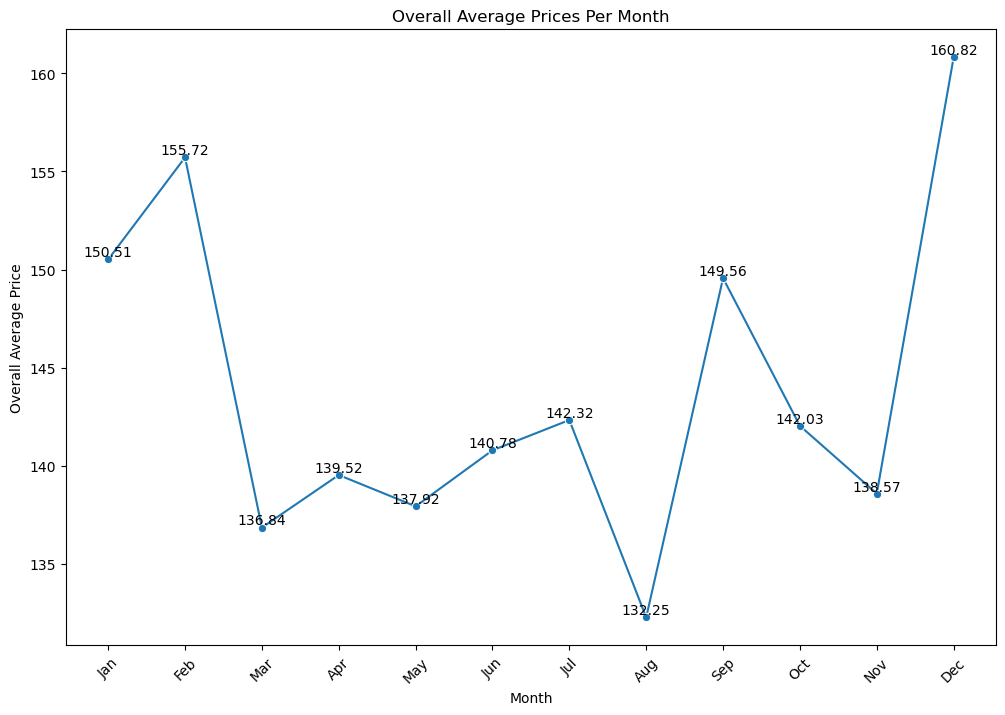

In [16]:
df['last_review'] = pd.to_datetime(df['last_review'])

#creating a temporary column to see the months
df['month'] = df['last_review'].dt.month

# group by month and calculate the overall average price for each month
overall_average_prices = df.groupby('month')['price'].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(x=overall_average_prices.index, y=overall_average_prices.values, marker='o')

# annotate values for each month on the plot
for month, price in zip(overall_average_prices.index, overall_average_prices.values):
    plt.text(month, price, f'{price:.2f}', ha='center', va='bottom')

plt.title('Overall Average Prices Per Month')
plt.xlabel('Month')
plt.ylabel('Overall Average Price')
plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
plt.show()

NOTE::: if it would possible to collect data on, for example, number of rents per month ( or even seasons), I believe it would be a great idea in order to analyze availability and price correlation with it, giving a better notion on how demand alters the prince range.

#### By analyzing the graphs results we can interpret that: ####

1. The analysis reveals a market trend of increased property availability towards the end of the year, suggesting a potential alignment with SEASONALITY of the market and higher demand during specific periods;

2. The positive correlation observed between the rolling averages of availability and the number of reviews indicates that as availability increases, the number of reviews tends to follow suit even though only mildly. This connection suggests a inclination on availability and guest reviews, potentially influenced by strategic adjustments made by property owners in response to seasonal variations and increased demand;

3. NOTE:::: To enhance this understanding, it would be ABSOLUTELY necessary to delve into deeper investigation, segment-specific analyses, considering different property types or locations and years (here I considered only 2018 for being the most recent year that I had the full data (jan-Dec));

3.1. Additionally, a cautious approach should be maintained, acknowledging that while correlation implies a relationship, causation requires further exploration of contributing factors and data integrity verification.

### Graph 7: geographical distribution of units by neighborhood group ###

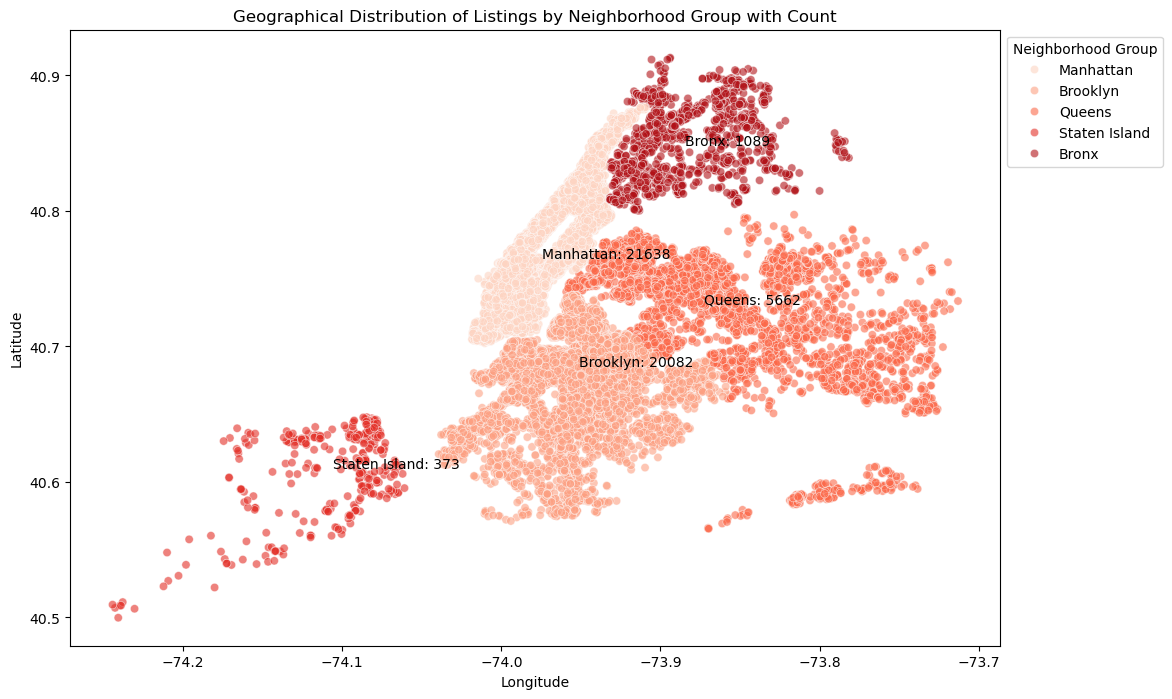

In [17]:
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='longitude', y='latitude', hue='neighborhood_group', data=df, palette='Reds', alpha=0.6)

# adding annotations for count by neighborhood group
counts_by_group = df['neighborhood_group'].value_counts()
for group, count in counts_by_group.items():
    group_data = df[df['neighborhood_group'] == group]
    centroid_longitude = group_data['longitude'].mean()
    centroid_latitude = group_data['latitude'].mean()
    scatter_plot.text(centroid_longitude, centroid_latitude, f'{group}: {count}', fontsize=10, color='black')

plt.title('Geographical Distribution of Listings by Neighborhood Group with Count')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Neighborhood Group', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The insights obtained by the geographical distribution gives us a clear vision that Manhattan and Brooklyn are, in that order and by alarge, the neighborhood groups with the most units available for rent. That is due to a higher demand or attractiveness to tourists, most likely influencing pricing and marketing strategies.


### Graph 8: prices vs neighborhood groups ###

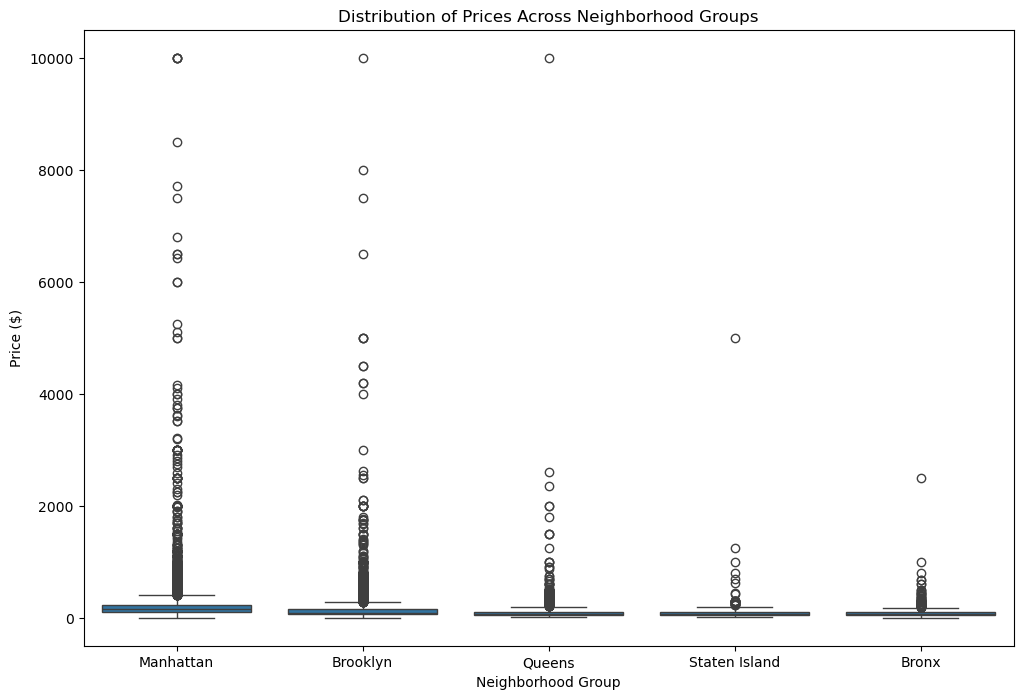

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='neighborhood_group', y='price', data=df)
plt.title('Distribution of Prices Across Neighborhood Groups')
plt.xlabel('Neighborhood Group')
plt.ylabel('Price ($)')
plt.show()

### Graph 9: avg prices vs neighborhood groups ###

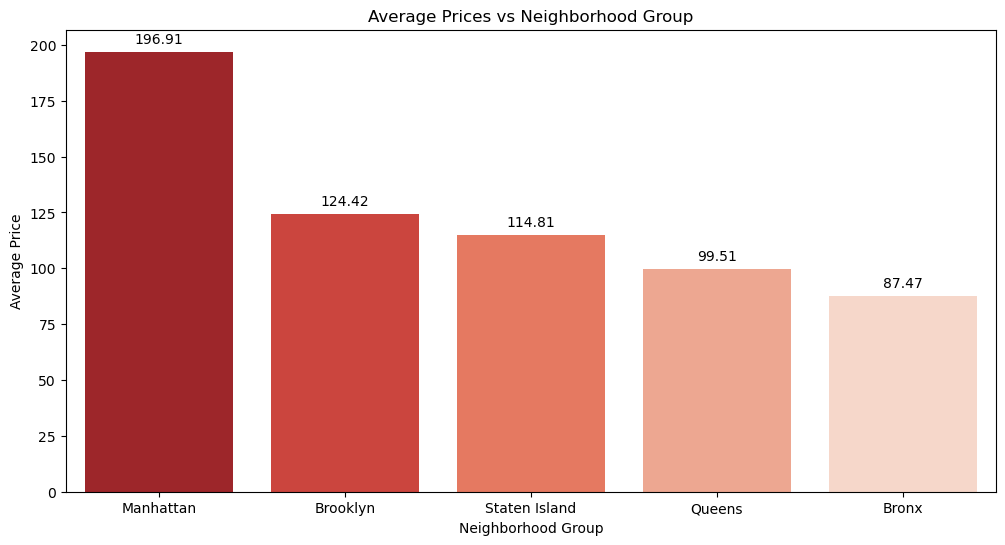

In [19]:
average_prices = df.groupby('neighborhood_group')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=average_prices.index, y=average_prices.values, hue=average_prices.index, palette='Reds_r', legend=False)

# loop to add to each bar  its respective value
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.title('Average Prices vs Neighborhood Group')
plt.xlabel('Neighborhood Group')
plt.ylabel('Average Price')
plt.show()

In [20]:
overall_mean_groupby = average_prices.mean()

# calculating the avg global price to see which neighborhood groups are above the global average:
overall_mean_groupby

124.62530477192499

In [21]:
# Identifying the row with the highest average price in each neighborhood group
sliced_df = df.groupby(['neighborhood_group', 'neighborhood'])['price'].mean().reset_index()

top_avg_prices = sliced_df.loc[sliced_df.groupby('neighborhood_group')['price'].idxmax()]
top_avg_prices

,neighborhood_group,neighborhood,price
34,Bronx,Riverdale,442.090909
88,Brooklyn,Sea Gate,487.857143
121,Manhattan,Tribeca,490.638418
163,Queens,Neponsit,274.666667
188,Staten Island,Fort Wadsworth,800.000000


 Finally, about the prices per neighborhood and taking into account graphs 7 to 9
:
 
1. For an investor seeking maximum profit probability in NYC real estate, strategic considerations center on neighborhoods with high demand, particularly in Manhattan and Brooklyn, known for consistent popularity;
2. the avg price analysis reveals potential investment opportunities, with a focus on areas that strike a balance between higher prices and steady demand. Luxury units, like those in Tribeca or exclusive locales such as Seagate in Brooklyn, present opportunities to attract high-end tourists. Seasonal pricing adjustments, diversification across neighborhoods, and local partnerships for added value are key strategies;
3. HOWEVER, staying informed about market trends by performing a wider, deeper market research, will contribute to long-term success;
4. Ultimately, understanding the unique selling points of each neighborhood and continuously adapting to market dynamics are crucial for making informed investment decisions with a high profit probability.

In [22]:
room_type_stats = df.groupby('room_type').agg({
    'price': ['mean', 'median', 'std'],
    'number_of_reviews': ['mean', 'median', 'std']
}).reset_index()
room_type_stats

room_type       price                    number_of_reviews         \
                          mean median         std              mean median   
0  Entire home/apt  211.826787  160.0  284.162863         22.840890    5.0   
1     Private room   89.797767   70.0  160.289546         24.120981    5.0   
2      Shared room   70.041451   45.0  101.791133         16.628670    4.0   

              
         std  
0  42.403065  
1  47.301171  
2  34.207566

### Graph 10: num of reviews per Room Type ###

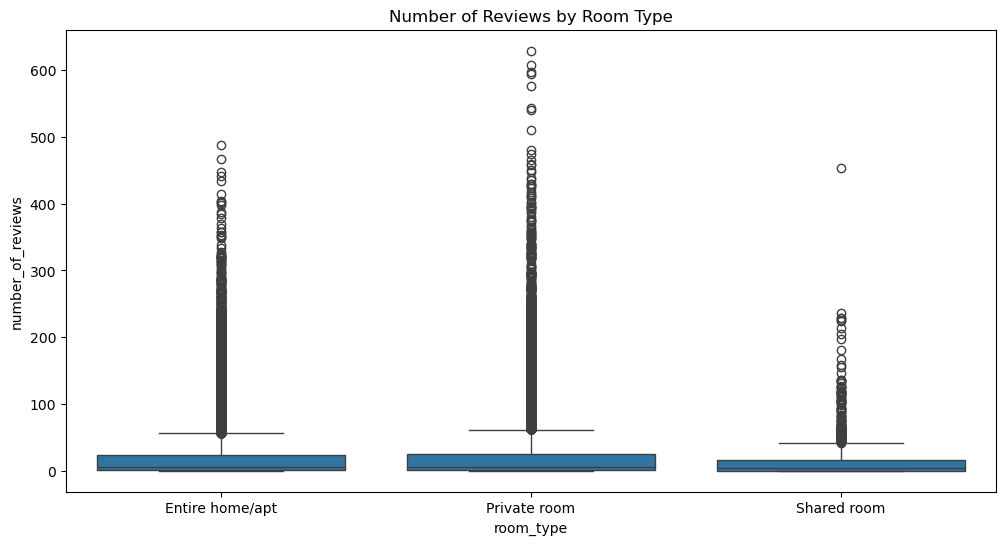

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='room_type', y='number_of_reviews')
plt.title('Number of Reviews by Room Type')
plt.show()


We can assume that, when looking only at the TYPE of room, it doesn't affect the number of reviews: Even though a more expensive room could tend to draw more reviews to it, a larger room doesn't seem to cause the same effect.

### Graph 11: Boxplot for prices vs Room Type ###

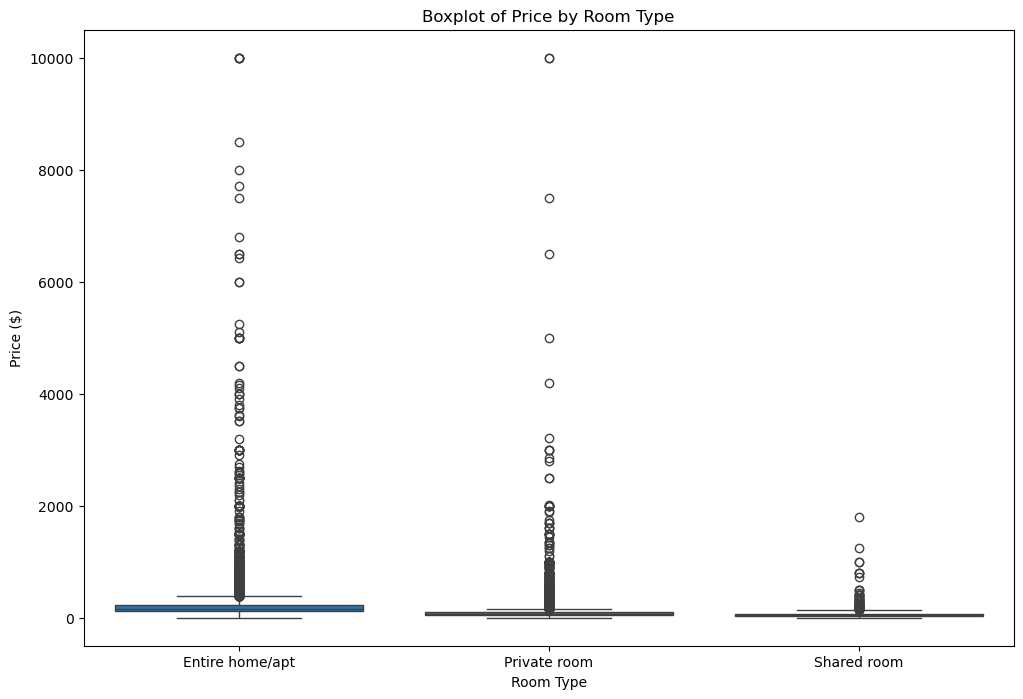

In [24]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Boxplot of Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show()

### Graph 12: barplot of room types per neighborhood group ###

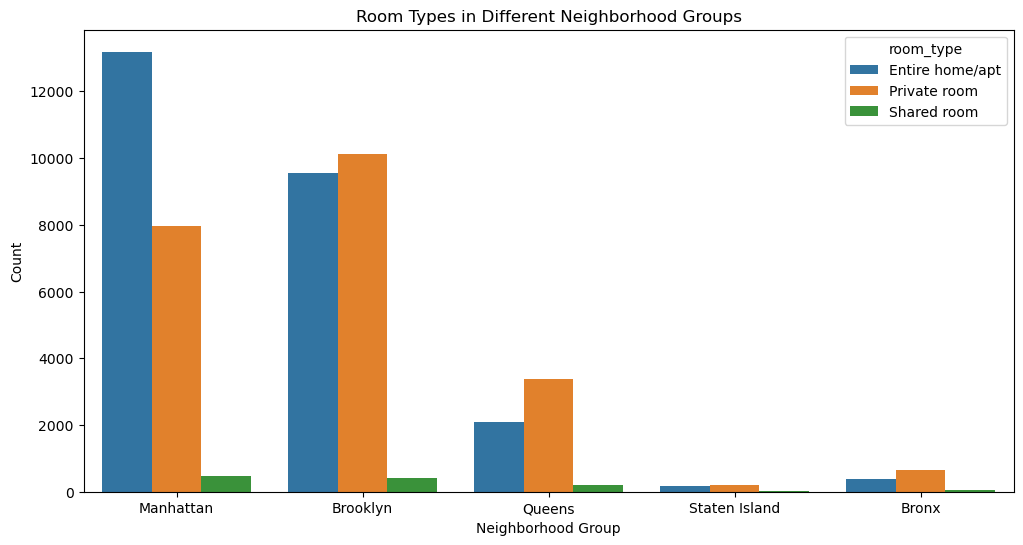

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(x='neighborhood_group', hue='room_type', data=df)
plt.title('Room Types in Different Neighborhood Groups')
plt.xlabel('Neighborhood Group')
plt.ylabel('Count')
plt.show()

1. The analysis reveals distinct pricing patterns across different room types;
2. Entire home/apartment listings tend to have higher prices on average, with a wider range of pricing. Private rooms offer a more moderate price range overall, while shared rooms represent a budget-friendly option;
3. Neighborhood groups influence rental prices, with Manhattan having higher-priced entire units. Room types play a role, but exceptions exist;
4. Temporal trends and host-related factors show correlations, but the data lacks granularity for precise conclusions;
5. Refinement of hypotheses, advanced modeling, and consideration of external data are recommended for improved precision.


### Graph 13: correlation matrix ###

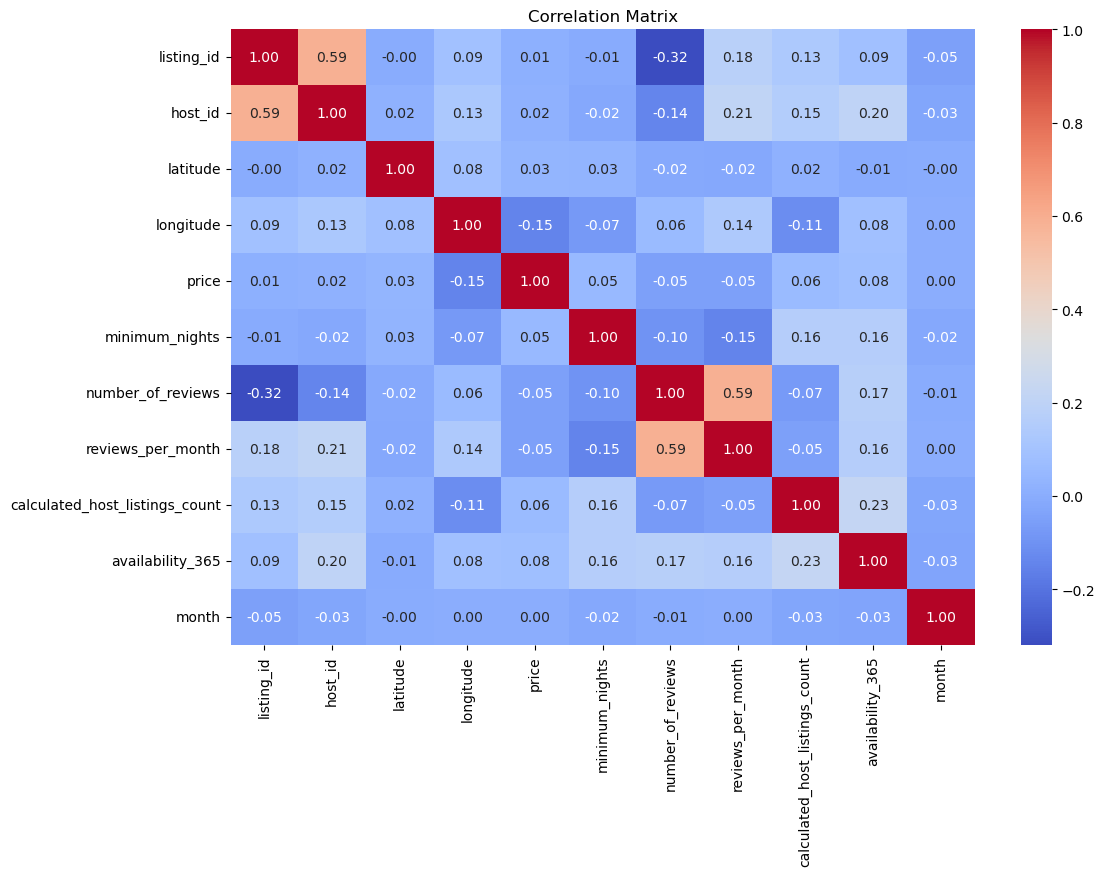

In [26]:
numeric_df = df.select_dtypes(include=['number'])

# Correlation matrix
correlation_matrix = numeric_df.corr()

# Display the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [27]:
# selecting the numerical features
numerical_features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

# select categorical features 
categorical_features = ['neighborhood_group', 'neighborhood', 'room_type', 'reviews_bins']

selected_features = numerical_features + categorical_features

# creating a df subset
subset_df = df[selected_features]

# converting categorical features to dummy variables
subset_df = pd.get_dummies(subset_df, columns=categorical_features, drop_first=True)

# missing values with the mean
subset_df.fillna(subset_df.mean(), inplace=True)

# extracting only the numeric columns for VIF calculation
numeric_columns = subset_df.select_dtypes(include=['float64', 'int64']).columns
X_numeric = subset_df[numeric_columns]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif_data)


                          Feature            VIF
0                        latitude  432256.486443
1                       longitude  432231.674204
2                           price       1.424987
3                  minimum_nights       1.264687
4               number_of_reviews       1.983458
5               reviews_per_month       2.307175
6  calculated_host_listings_count       1.136145
7                availability_365       1.978917


## NLP Analysis of Listing Names: ##


In [28]:
# function for text preprocessing (removing utf=8 characters, converting to lower and tokenization)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower() 
    words = word_tokenize(text)  
    words = [word for word in words if word not in stopwords.words('english')]  
    return ' '.join(words)  

# text preprocessing to the 'name' column
df['name_processed'] = df['name'].apply(preprocess_text)

2. Word Frequency Analysis:

                                     name_processed    price
18432              furnished room astoria apartment  10000.0
25649   luxury bedroom apt stunning manhattan views  10000.0
6097                              br lincoln center  10000.0
34420                 quiet clean lit les chinatown   9999.0
6069        br heart nyc manhattans lower east side   9999.0
39525                            spanish harlem apt   9999.0
3755   beautifulspacious bed luxury flattribecasoho   8500.0
17885                                 film location   8000.0
16414               east nd townhouse hidden airbnb   7703.0
18618                             gem east flatbush   7500.0


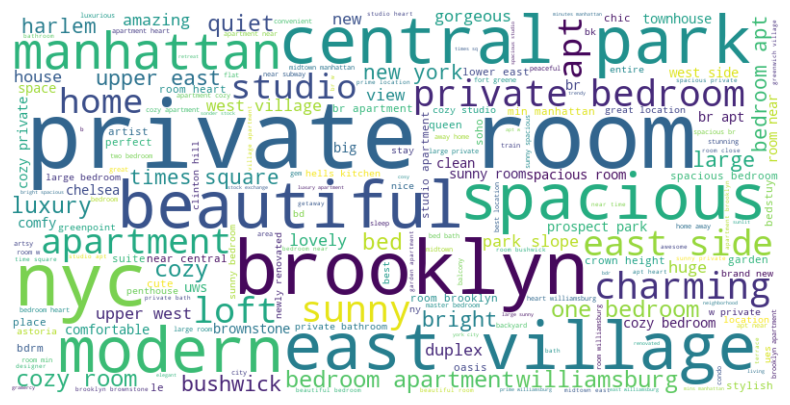

In [29]:
# group by name processed and calculate the average price for each group
average_prices = df.groupby('name_processed')['price'].mean().reset_index()

# sort by average price in descending order to IDENTIFY the names associated with higher prices
sorted_names = average_prices.sort_values(by='price', ascending=False)

#top names associated with higher prices
top_names_high_prices = sorted_names.head(10)
print(top_names_high_prices)

# Generate a wordcloud for visualization
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(df['name_processed']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The larger font size of certain words indicates that these terms are more common in the dataset. 
So: 

"Central Park"
"Beautiful"
"Private Room"
"Brooklyn"
"Spacious"
"NYC"
"East Village"
"Modern"
"Manhattan"
These terms are likely popular descriptors for the listed accommodations and contribute to a higher average price, as seen in the analysis. The prominence of these words in the word cloud suggests that they play a role in attracting attention and potentially influencing pricing in the Airbnb listings.

# Building a model for price forecasting #

#### NOTE REGARDING PRICE FORECASTING AND PRICE OUTLIERS FOR ANSWERING QUESTION 3. ::: ####

I have chosen to keep the price outliers for my analysis, considering that:

1. The goal is to predict prices for apartments in a diverse market, including luxury units;
2. Removing extreme prices might result in a loss of valuable information about the market's variability.



avg price 143.9
high price months: jan, feb, sep, dec
shoulder price: jun, jul, oct
low prices: mar, apr, may, aug, nov

. After the EDA, I have decided to take into consideration for this predictive model the following variables as var pred.:

'nighborhood'
'room_type'
'minimun_nights'
'number_of_reviews'
availability 365?????????

In [30]:
df.head(20
    )

,listing_id,name,host_id,host_name,neighborhood_group,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,reviews_bins,month,name_processed
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,"(0.0, 50.0]",5.0,skylit midtown castle
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,0.00,1,365,NaN,NaN,village harlemnew york
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,"(250.0, 300.0]",7.0,cozy entire floor brownstone
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,"(0.0, 50.0]",11.0,entire apt spacious studioloft central park
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,"(50.0, 100.0]",6.0,large cozy br apartment midtown east
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0,"(0.0, 50.0]",10.0,blissartsspace
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220,"(400.0, 450.0]",6.0,large furnished room near bway
7,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0,"(100.0, 150.0]",7.0,cozy clean guest room family apt
8,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188,"(150.0, 200.0]",6.0,cute cozy lower east side bdrm
9,5295,Beautiful 1br on Upper West Side,7702,Lena,Manhattan,Upper West Side,40.80316,-73.96545,Entire home/apt,135,5,53,2019-06-22,0.43,1,6,"(50.0, 100.0]",6.0,beautiful br upper west side


### Feature Engineering - Adding a Count for Specific Terms: ###


In the following code:

1. I selected the relevant columns from the original DataFrame (df_encoded).
2. Rows with missing values are dropped to ensure data consistency.
3. The data is split into training and testing sets (80% training, 20% testing).
4. The features are standardized using StandardScaler to bring them to a similar scale.
5. A linear regression model is initialized, trained on the training set, and evaluated on the test set.
6. Model coefficients and intercept are printed for interpretation.

In [31]:

terms = ["Central Park", "Beautiful", "Private Room", "private bedroom", "Brooklyn",
         "Sunny", "Spacious", "NYC", "East Village", "east Side", "charming",
         "Modern", "Manhattan"]

# Function to check if the name contains any of the terms
def contains_keyword(name):
    if pd.isnull(name):  # Check for nan values to avoid errors during search
        return 0
    for term in terms:
        # Using case insensitive search
        if re.search(term, name, re.IGNORECASE):
            return 1
    return 0

# new binary column
df['has_keyword'] = df['name'].apply(contains_keyword)

### Beginning of data preparation ###

In [32]:
columns_to_use = ['neighborhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 
                  'has_keyword', 'availability_365']

df_model = df[columns_to_use].copy()

df_model['number_of_reviews'] = df_model['number_of_reviews'].fillna(0)
df_model['availability_365'] = df_model['availability_365'].fillna(df_model['availability_365'].median())

df_model = pd.get_dummies(df_model, columns=['neighborhood_group', 'room_type'], drop_first=True)

df_model['log_availability_365'] = np.log1p(df_model['availability_365'])

bins = [0, 120, 240, 365]
labels = ['Low', 'Medium', 'High']
df_model['availability_bins'] = pd.cut(df_model['availability_365'], bins=bins, labels=labels, include_lowest=True)

# bins to dummy variables
df_model = pd.get_dummies(df_model, columns=['availability_bins'], drop_first=True)
df_model = df_model.drop(columns=['availability_365'])
df_model

,minimum_nights,number_of_reviews,has_keyword,neighborhood_group_Brooklyn,neighborhood_group_Manhattan,neighborhood_group_Queens,neighborhood_group_Staten Island,room_type_Private room,room_type_Shared room,log_availability_365,availability_bins_Medium,availability_bins_High
0,1,45,0,False,True,False,False,False,False,5.874931,False,True
1,3,0,0,False,True,False,False,True,False,5.902633,False,True
2,1,270,0,True,False,False,False,False,False,5.273000,True,False
3,10,9,1,False,True,False,False,False,False,0.000000,False,False
4,3,74,0,False,True,False,False,False,False,4.867534,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
48889,2,0,1,True,False,False,False,True,False,2.302585,False,False
48890,4,0,0,True,False,False,False,True,False,3.610918,False,False
48891,10,0,1,False,True,False,False,False,False,3.332205,False,False
48892,1,0,0,False,True,False,False,False,True,1.098612,False,False


In [33]:
df_model['price'] = df['price']

# Defining the features (X) and the target variable (y)
X = df_model.drop('price', axis=1)  # Features
y = df_model['price']  # Target variable

# Splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head())


       minimum_nights  number_of_reviews  has_keyword  \
48886               1                  0            0   
31138               2                 33            1   
33860               2                 13            1   
14531               4                  6            0   
23437               1                  2            0   

       neighborhood_group_Brooklyn  neighborhood_group_Manhattan  \
48886                         True                         False   
31138                         True                         False   
33860                        False                         False   
14531                         True                         False   
23437                        False                          True   

       neighborhood_group_Queens  neighborhood_group_Staten Island  \
48886                      False                             False   
31138                      False                             False   
33860                       True      

In [34]:
bool_cols = [col for col in df_model.columns if df_model[col].dtype == 'bool']
df_model[bool_cols] = df_model[bool_cols].astype(int)

# Define features and target variable
X = df_model.drop('price', axis=1) 
y = df_model['price']  

#training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Linear Regression model
linear_reg = LinearRegression()

# Train the model
linear_reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = linear_reg.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 56700.78507443673
Root Mean Squared Error: 238.11926649147216
R^2 Score: 0.0896112114512233


#### Trying to improve the model by removing price outliers:: ####

Since previous LR came pretty bad in terms of R² score (0.089) I will try to remove price outliers for the sake of the predictiveness

In [35]:
df_model.head()

,minimum_nights,number_of_reviews,has_keyword,neighborhood_group_Brooklyn,neighborhood_group_Manhattan,neighborhood_group_Queens,neighborhood_group_Staten Island,room_type_Private room,room_type_Shared room,log_availability_365,availability_bins_Medium,availability_bins_High,price
0,1,45,0,0,1,0,0,0,0,5.874931,0,1,225
1,3,0,0,0,1,0,0,1,0,5.902633,0,1,150
2,1,270,0,1,0,0,0,0,0,5.273000,1,0,89
3,10,9,1,0,1,0,0,0,0,0.000000,0,0,80
4,3,74,0,0,1,0,0,0,0,4.867534,1,0,200


In [36]:
# quarters Q1 and Q3
Q1 = df_model['price'].quantile(0.25)
Q3 = df_model['price'].quantile(0.75)

# Interquartile range (IQR)
IQR = Q3 - Q1

# outliers difened as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Filter out the outliers
df_filtered = df_model[(df_model['price'] >= lower_bound) & (df_model['price'] <= upper_bound)]

print(f"Original DataFrame size: {df_model.shape}")
print(f"Filtered DataFrame size: {df_filtered.shape}")
df_filtered.head()

Original DataFrame size: (48844, 13)
Filtered DataFrame size: (45873, 13)


,minimum_nights,number_of_reviews,has_keyword,neighborhood_group_Brooklyn,neighborhood_group_Manhattan,neighborhood_group_Queens,neighborhood_group_Staten Island,room_type_Private room,room_type_Shared room,log_availability_365,availability_bins_Medium,availability_bins_High,price
0,1,45,0,0,1,0,0,0,0,5.874931,0,1,225
1,3,0,0,0,1,0,0,1,0,5.902633,0,1,150
2,1,270,0,1,0,0,0,0,0,5.273000,1,0,89
3,10,9,1,0,1,0,0,0,0,0.000000,0,0,80
4,3,74,0,0,1,0,0,0,0,4.867534,1,0,200


## Linear Regression model

In [37]:
X_filtered = df_filtered.drop('price', axis=1)  #features
y_filtered = df_filtered['price']  #target variable

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
linear_reg_filtered = LinearRegression()

linear_reg_filtered.fit(X_train_filtered, y_train_filtered)

y_pred_filtered = linear_reg_filtered.predict(X_test_filtered)

# Calculate and print metrics
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = np.sqrt(mse_filtered)
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

print(f"Mean Squared Error (Filtered): {mse_filtered}")
print(f"Root Mean Squared Error (Filtered): {rmse_filtered}")
print(f"R^2 Score (Filtered): {r2_filtered}")


Mean Squared Error (Filtered): 2441.4955193057376
Root Mean Squared Error (Filtered): 49.411491773733545
R^2 Score (Filtered): 0.4715653584168261


### Trying Random Forest Regressor to improve the results ###

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = df_filtered.drop('price', axis=1)  # Exclude the target variable 'price'
y = df_filtered['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

# Calculate metrics
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - Root Mean Squared Error: {rmse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")


Random Forest - Mean Squared Error: 2680.6637827676996
Random Forest - Root Mean Squared Error: 51.77512706664948
Random Forest - R^2 Score: 0.419800038930788


### Trying Ridge Regression with Hyperparameter 
 ###

In [39]:
## Define a range of alpha values for ridgecv to explore
alphas = np.logspace(-6, 6, 13)

# Create a pipeline that first standardizes the data then applies ridgecv
pipeline = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, store_cv_values=True))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Extract the ridgecv model from the pipeline
ridge_model = pipeline.named_steps['ridgecv']

y_pred_ridge = pipeline.predict(X_test)

# Calculate metrics for Ridge Regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Optimal alpha: {ridge_model.alpha_}")
print(f"Ridge Regression - Mean Squared Error: {mse_ridge}")
print(f"Ridge Regression - Root Mean Squared Error: {rmse_ridge}")
print(f"Ridge Regression - R^2 Score: {r2_ridge}")


Optimal alpha: 10.0
Ridge Regression - Mean Squared Error: 2441.566600527519
Ridge Regression - Root Mean Squared Error: 49.412211046739436
Ridge Regression - R^2 Score: 0.47154997367429496


# Answering question 3 #

Unfortunately, none of my ML models reached a satisfactory predition and I was unable to improve it enough with the time frame that I had to work with it. However here are my final thoughts and breakdown:

1. This is a regression problem because the outcome variable (price) is continuous, and we aim to predict its value based on the input features;

2. The variables chosen include minimum_nights, number_of_reviews, availability_365, and room_type, along with derived variables like has_keyword (indicating if the listing's name contains keywords) and location-based dummies (neighborhood_group_Brooklyn, neighborhood_group_Manhattan, etc.);

3. R² Score and Root Mean Squared Error (RMSE) were chosen as the performance measures;

4. The decision to focus on R² Score and RMSE as performance measures was driven by the need to understand both the proportion of variance explained by the model and the average magnitude of the model's prediction errors, respectively, which are crucial for evaluating and improving the model's predictive power.

The Random Forest Regressor emerged as a strong candidate among the models tested, including Linear Regression, Decision Tree, and Ridge Regression.
Pros: Random Forest can handle non-linear relationships without explicit feature engineering for interactions, is less prone to overfitting than Decision Trees due to its ensemble nature, and automatically assesses feature importance.
Cons: It is more computationally intensive than Linear Regression, offers less interpretability due to its complexity, and requires careful hyperparameter tuning to avoid overfitting and ensure optimal performance.

# Answering question 4 #

In [40]:
# creating a separate df to analyze the ap data:
apartment_data = {
    'minimum_nights': 1,
    'number_of_reviews': 45,
    'has_keyword': 0,
    'neighborhood_group_Brooklyn': 0,
    'neighborhood_group_Manhattan': 1,
    'neighborhood_group_Queens': 0,
    'neighborhood_group_Staten Island': 0,
    'room_type_Private room': 0,
    'room_type_Shared room': 0,
    'log_availability_365': 5.875,
    'availability_bins_Medium': 0,
    'availability_bins_High': 1
}


In [41]:
apartment_df = pd.DataFrame([apartment_data])
apartment_df


,minimum_nights,number_of_reviews,has_keyword,neighborhood_group_Brooklyn,neighborhood_group_Manhattan,neighborhood_group_Queens,neighborhood_group_Staten Island,room_type_Private room,room_type_Shared room,log_availability_365,availability_bins_Medium,availability_bins_High
0,1,45,0,0,1,0,0,0,0,5.875,0,1


In [42]:
predicted_price = linear_reg_filtered.predict(apartment_df)

predicted_price[0]

193.90857954894096

In [43]:
models = {'ln_model': r2_filtered, 'rr_model': r2_ridge, 'rf_model': r2_rf}  

for name, df in models.items():
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(df, file)